# Case Fatality Rate - Exploratory Data Analysis at Country Wide Level

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import urllib.request
from bs4 import BeautifulSoup
import csv

import os
import re

import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

plt.style.use('seaborn-whitegrid')

In [150]:
# outbreak class to organize infections + death dfs in one. 
def get_top_regions(df):
    return df.iloc[-1].sort_values(ascending=False).index.tolist()

class Outbreak:
    def __init__(self, name):
        self.name = name
        
        self.base_epidemic_curve = None
        self.base_fatality_curve = None
        
        self.top_regions = None
        self.should_filter_top_regions = False
        
    def filter_top_regions(self, top_n=10):
        self.top_regions = get_top_regions(self.epidemic_curve)[:top_n]
        self.should_filter_top_regions = True
        
    def filter_all_regions(self):
        self.should_filter_top_regions = False
        
    def apply_filters(self, df):
        if self.should_filter_top_regions:
            return df[self.top_regions]
        
        return df
    
    def get_region_df(self, region):
        if region not in self.base_epidemic_curve.columns:
            raise Exception("No such region in base dataframe.") 
            
        return pd.DataFrame({"Infected": self.base_epidemic_curve[region], "Dead": self.base_fatality_curve[region]}, index=self.epidemic_curve.index)
        
    @property
    def epidemic_curve(self):
        return self.apply_filters(self.base_epidemic_curve)
        
    def set_epidemic_curve(self, df):
        if self.base_epidemic_curve is not None:
            raise Exception("Epidemic curve already set!")
            
        self.base_epidemic_curve = df
        
    @property
    def fatality_curve(self):
        return self.apply_filters(self.base_fatality_curve)
        
    def set_fatality_curve(self, df):
        if self.base_fatality_curve is not None:
            raise Exception("Fatality curve already set!")
            
        self.base_fatality_curve = df
        
    @property
    def cfr_curve(self):
        assert self.epidemic_curve is not None and self.fatality_curve is not None
        
        return (self.fatality_curve / self.epidemic_curve)
    
    def add_plot_details(self, ax, plotname, savefig=False):
        plt.title(f"{self.name} - {plotname}")
        
        if savefig:
            plt.savefig(f"../plots/{self.name}/{plotname}.pdf")
            
        plt.show()
        
    def convert_indices_to_timedelta_since_epidemic_start_date(self):
        assert self.epidemic_curve is not None and self.fatality_curve is not None
        
        self.epidemic_start_date = min(pd.to_datetime(self.epidemic_curve.index))
        
        self.epidemic_curve.index = pd.to_datetime(self.epidemic_curve.index) - self.epidemic_start_date
        self.fatality_curve.index = pd.to_datetime(self.fatality_curve.index) - self.epidemic_start_date

## SARS

In [106]:
sars_df = pd.read_csv('../data/time_series/cumulative/SARS.csv', index_col=0)

sars_df.head(5)

,Infected,Dead
Dates,,
2003-03-17,167,4
2003-03-18,219,4
2003-03-19,264,9
2003-03-20,306,10
2003-03-21,350,10


In [107]:
sars = Outbreak("sars")

sars.set_epidemic_curve(sars_df['Infected'])
sars.set_fatality_curve(sars_df['Dead'])

sars.convert_indices_to_timedelta_since_epidemic_start_date()

### CFR

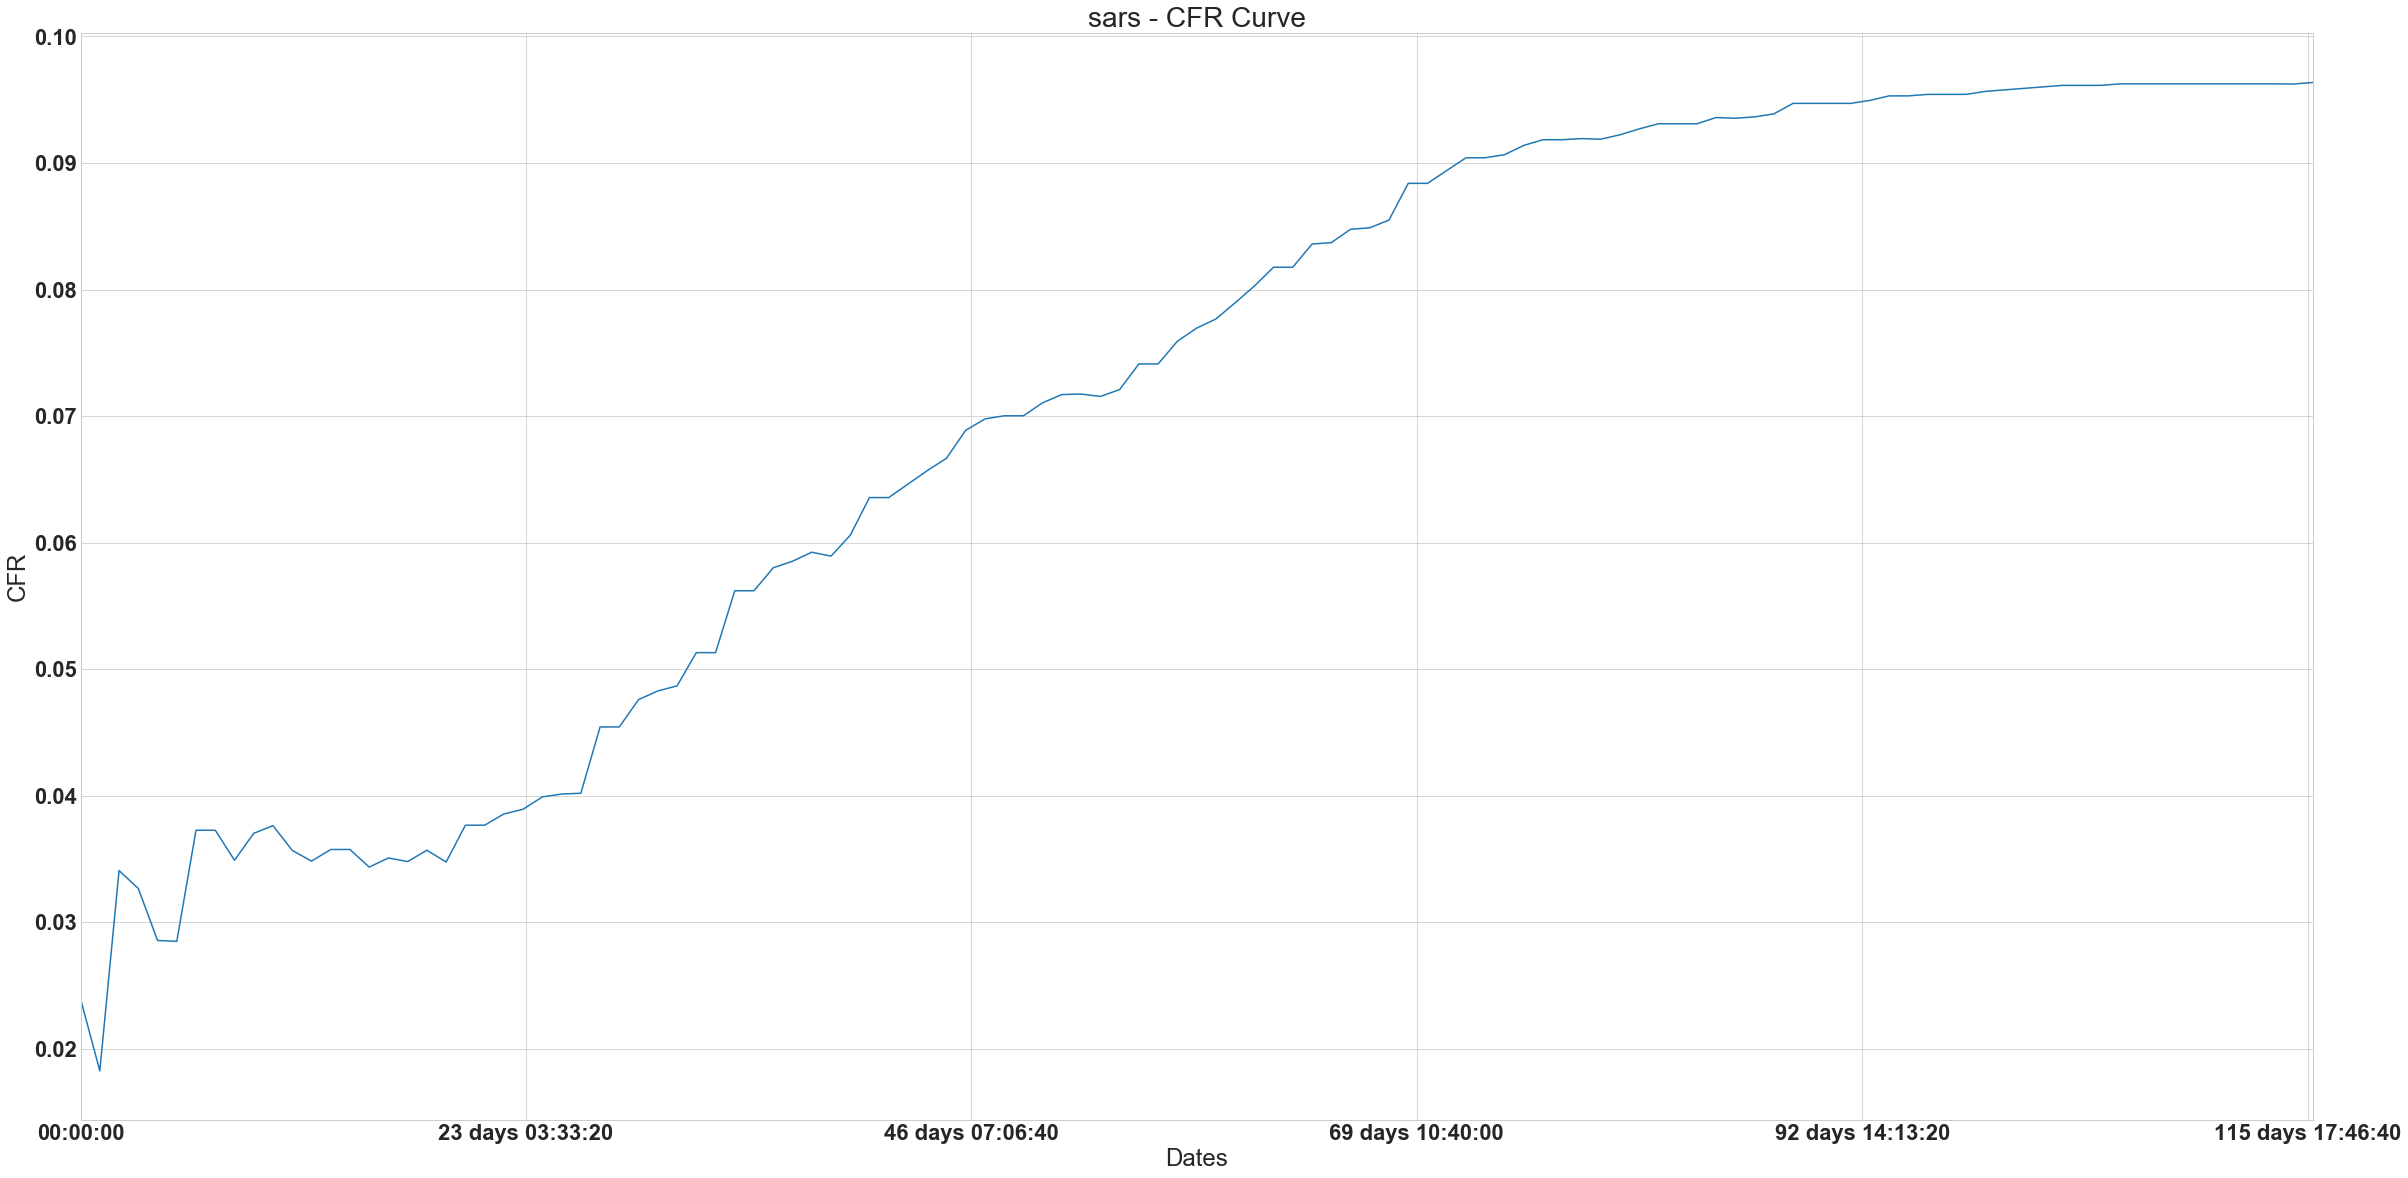

In [108]:
ax = plt.gca(ylabel="CFR")

sars.cfr_curve.plot()
sars.add_plot_details(ax, "CFR Curve")

### Fatality Curves

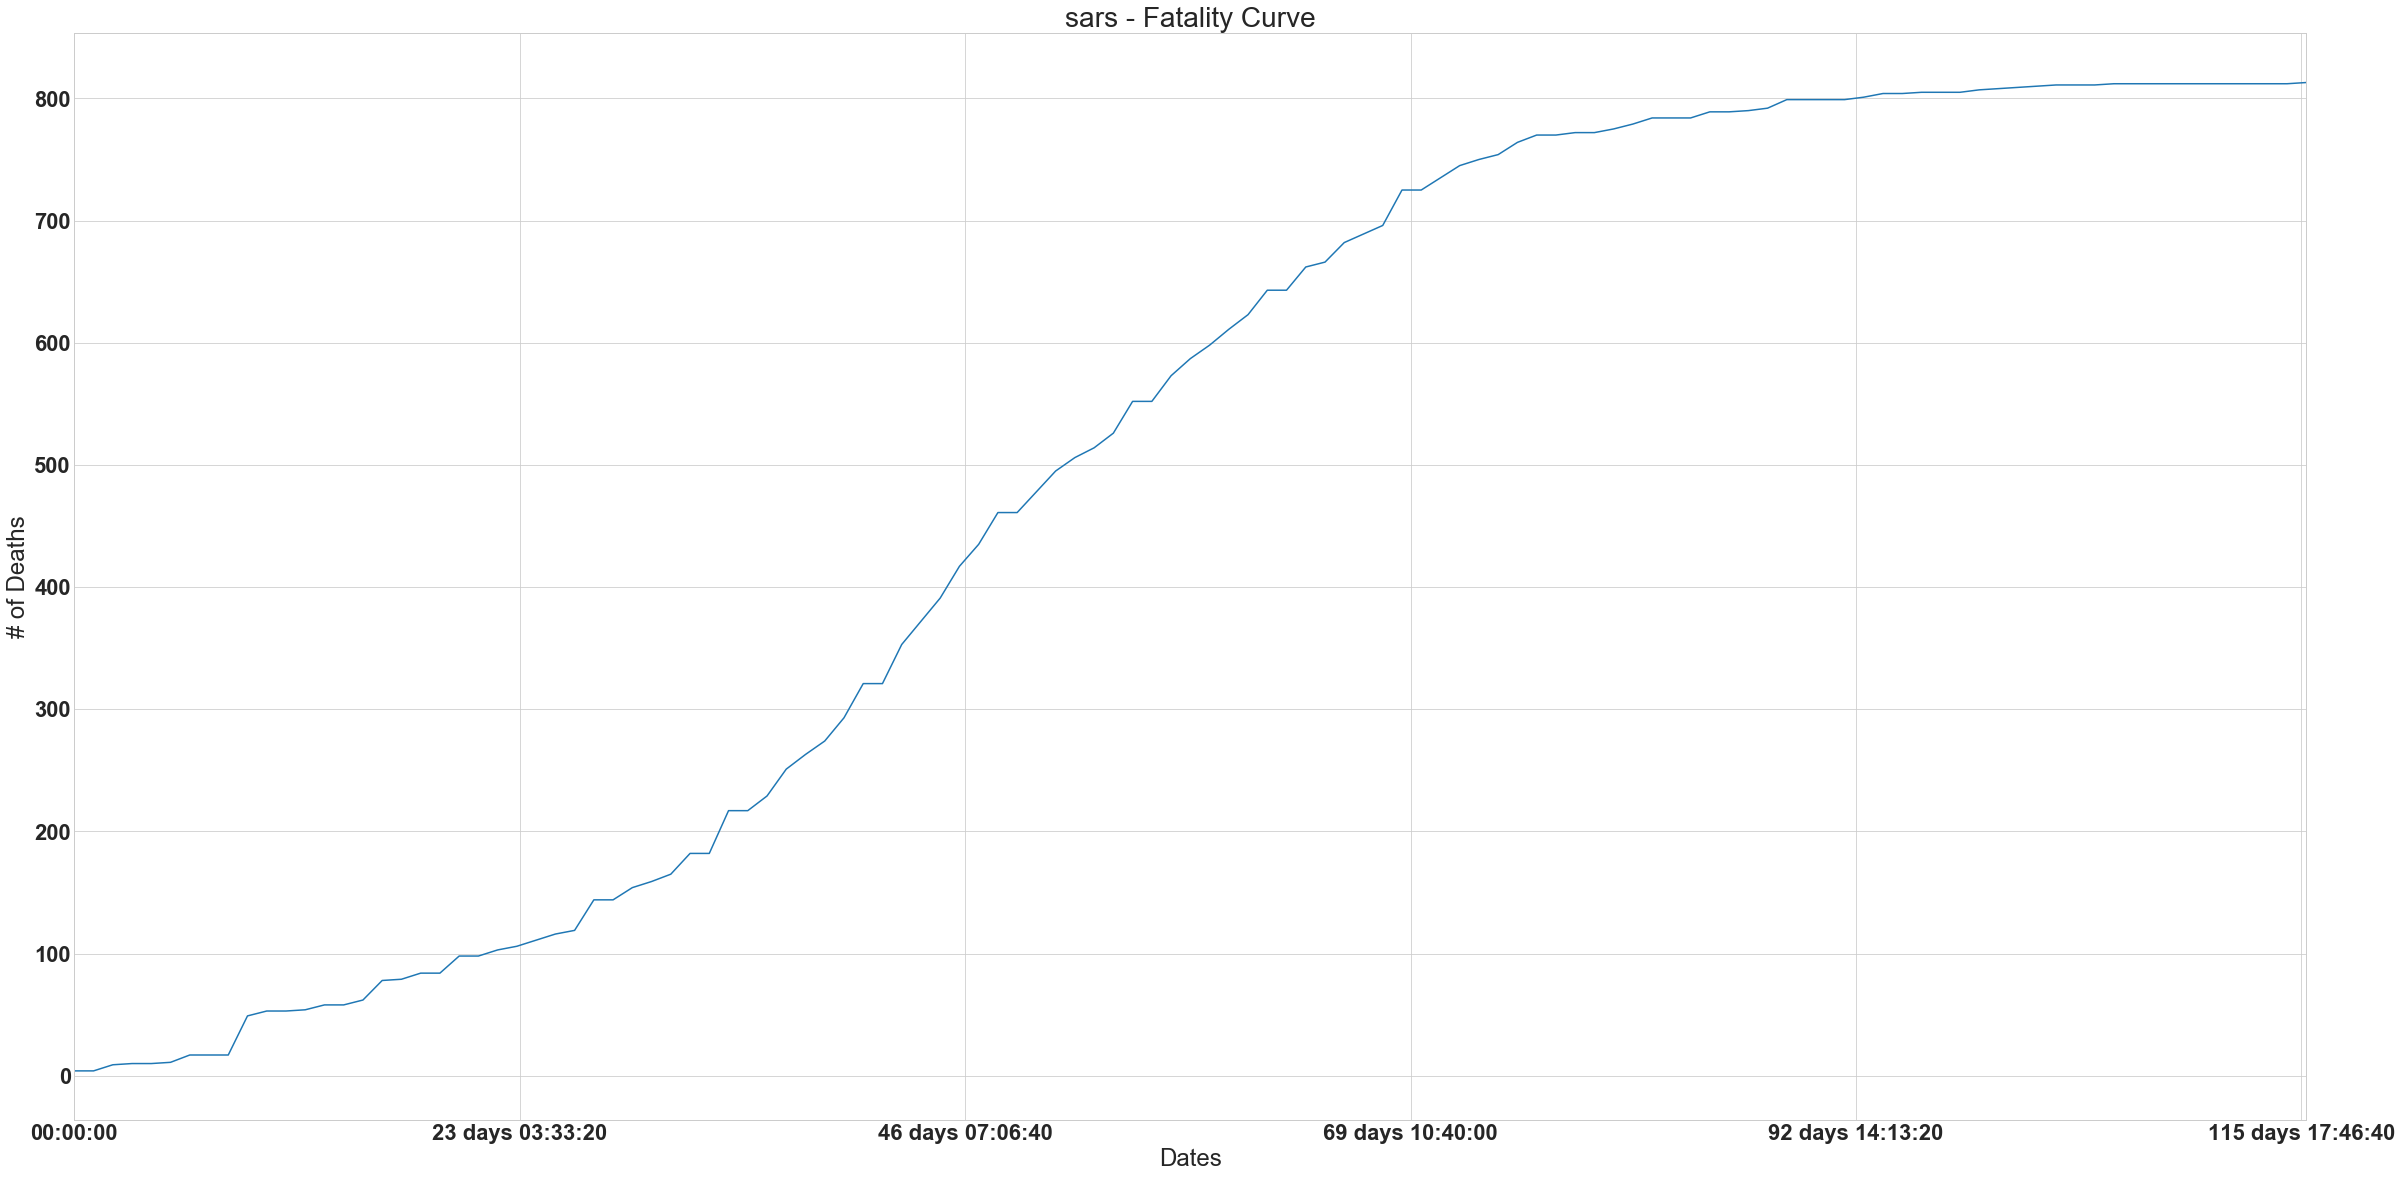

In [161]:
ax = plt.gca(ylabel="# of Deaths")

sars.fatality_curve.plot()
sars.add_plot_details(ax, "Fatality Curve")

## Coronavirus

### Global

In [151]:
global_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')\
                        .drop(["Lat", "Long", "Province/State"], axis=1)\
                        .groupby('Country/Region').sum()\
                        .transpose()

global_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')\
                    .drop(["Lat", "Long", "Province/State"], axis=1)\
                    .groupby('Country/Region').sum()\
                    .transpose()

In [152]:
global_coronavirus_outbreak = Outbreak("global_coronavirus")

global_coronavirus_outbreak.set_epidemic_curve(global_confirmed_df)
global_coronavirus_outbreak.set_fatality_curve(global_death_df)

global_coronavirus_outbreak.convert_indices_to_timedelta_since_epidemic_start_date()

We will filter the entire dataset by the 10 most impacted regions in the world for simplicity. As we can see below, these regions account for 80% of total confirmed cases and 88% of cases. We consider this coverage sufficient to be representative of the whole.

In [153]:
global_coronavirus_outbreak.filter_top_regions()

In [124]:
top_regions_total_number_of_cases = global_coronavirus_outbreak.epidemic_curve.sum(axis=1)[-1]
global_total_number_of_cases = global_coronavirus_outbreak.base_epidemic_curve.sum(axis=1)[-1]

top_regions_total_number_of_deaths = global_coronavirus_outbreak.fatality_curve.sum(axis=1)[-1]
global_total_number_of_deaths = global_coronavirus_outbreak.base_fatality_curve.sum(axis=1)[-1]

print("Case coverage=%.2f" % ((top_regions_total_number_of_cases / global_total_number_of_cases) * 100))
print("Death coverage=%.2f" % ((top_regions_total_number_of_deaths / global_total_number_of_deaths) * 100))

Case coverage=80.08
Death coverage=87.91


### CFR

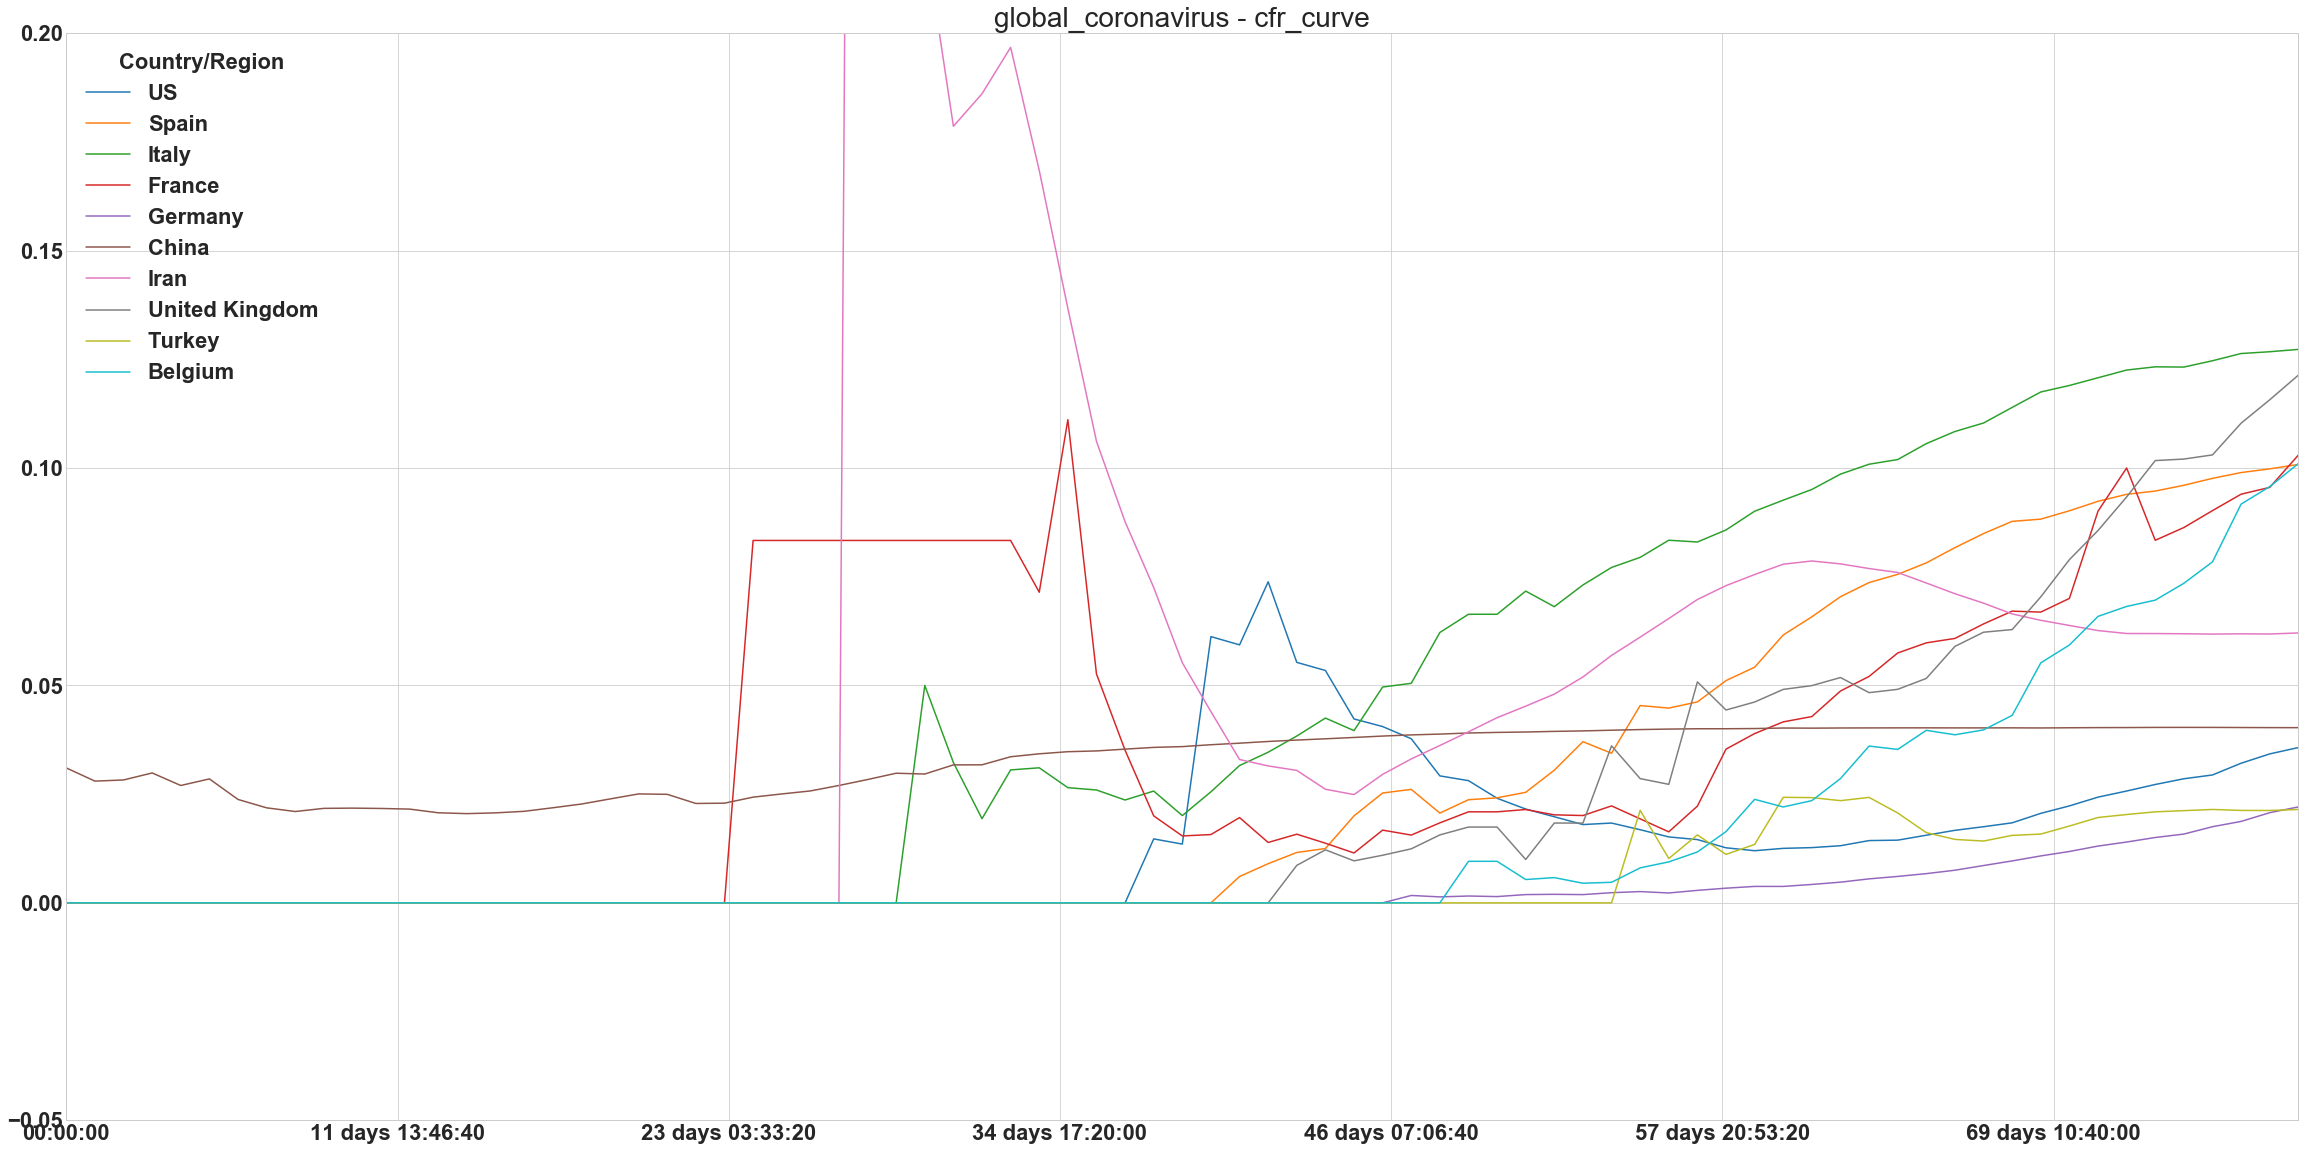

In [99]:
ax = plt.gca()

global_coronavirus_outbreak.cfr_curve().fillna(0).plot(ylim=[-0.05, 0.2], ax=ax)

global_coronavirus_outbreak.add_plot_details(ax, "cfr_curve")

#### Epidemic Curve

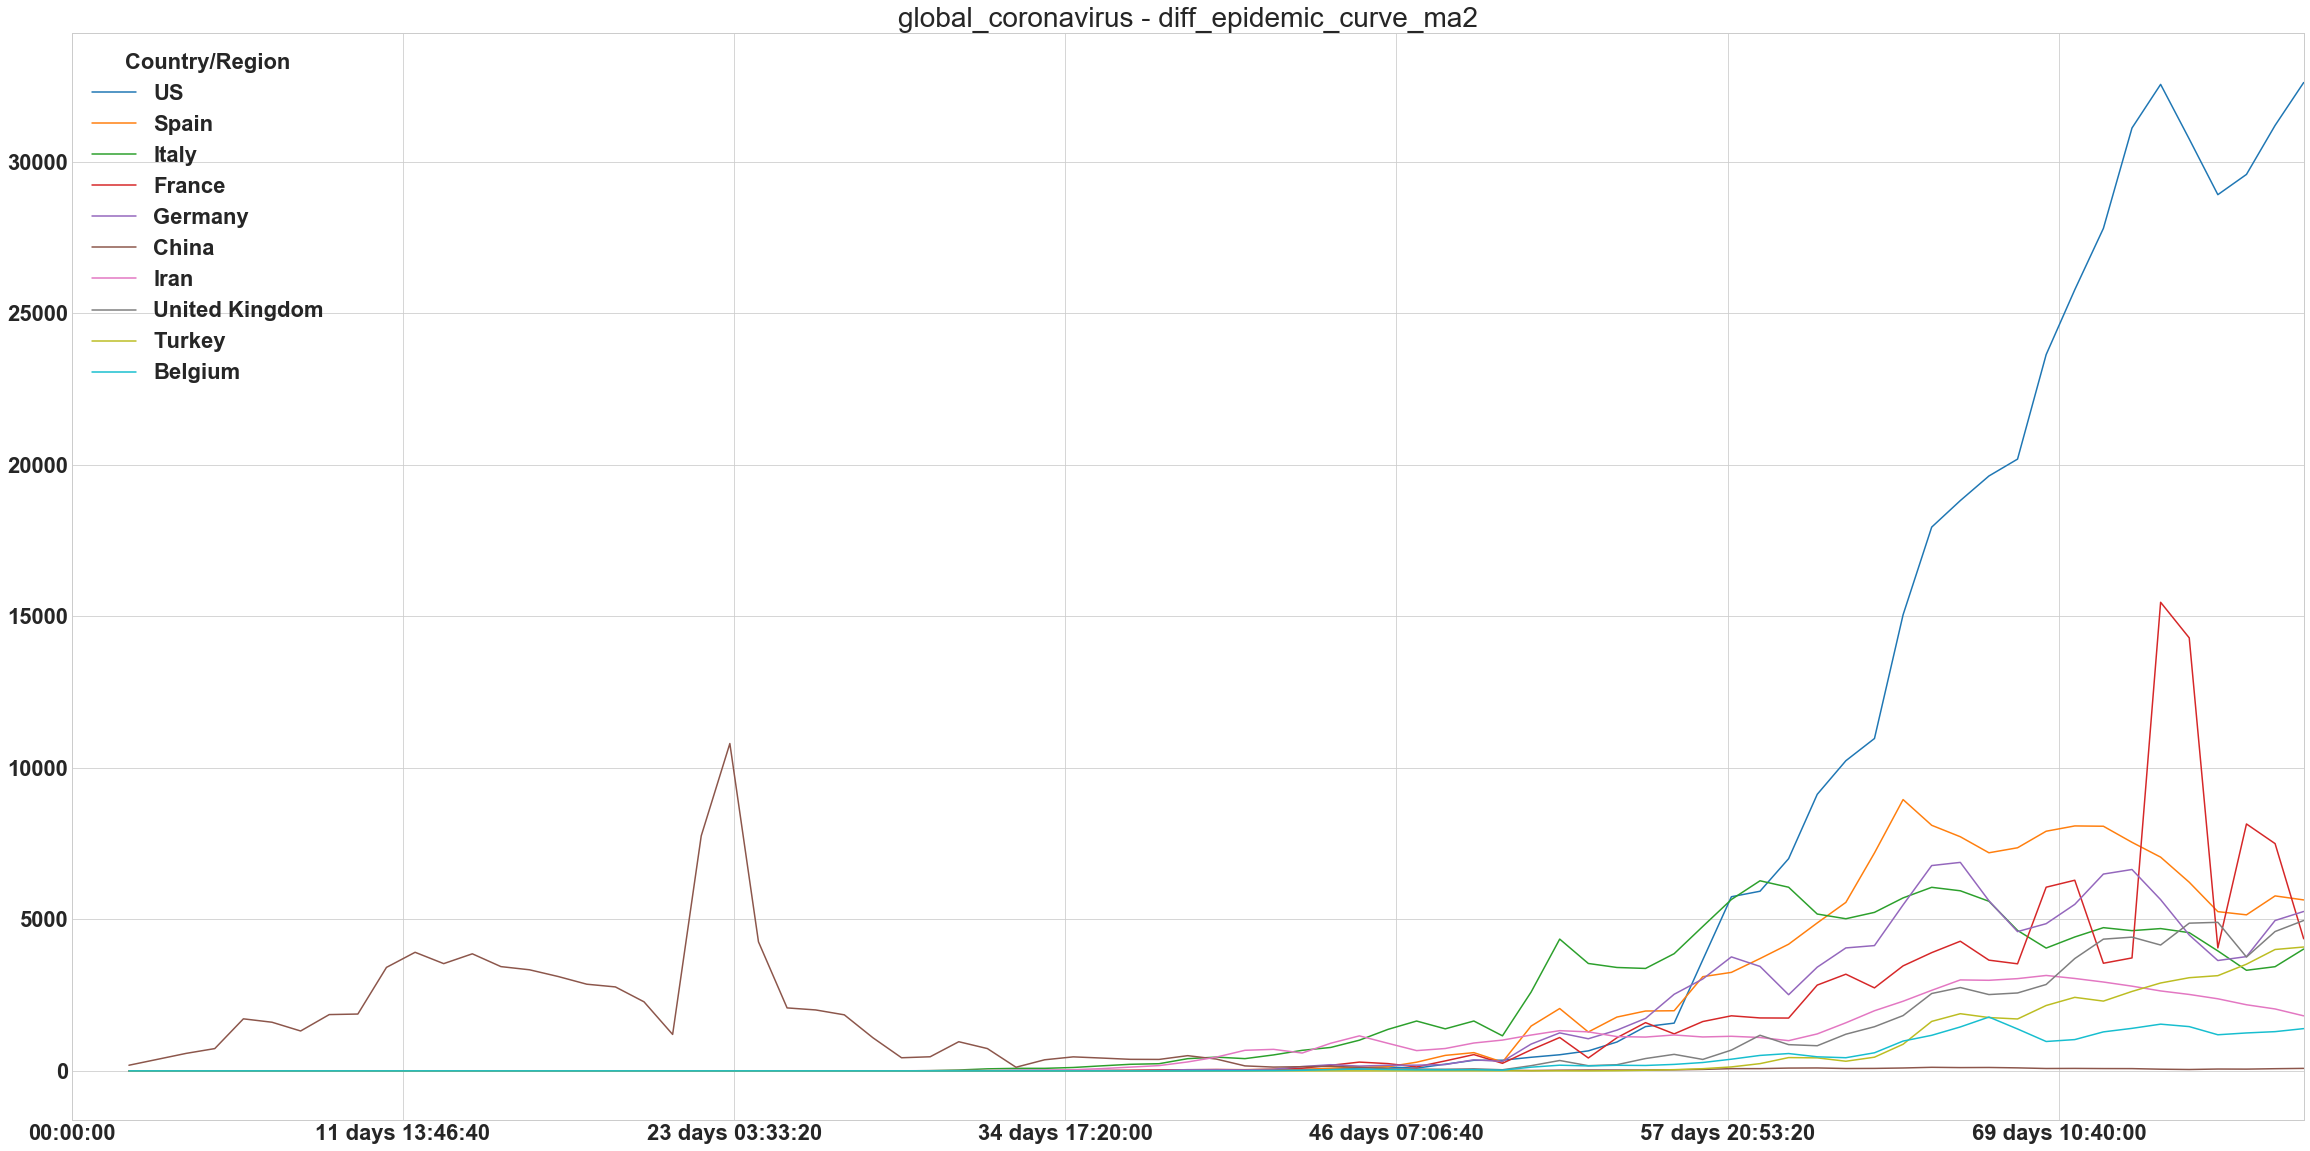

In [136]:
ax = plt.gca()

global_coronavirus_outbreak.epidemic_curve.diff().rolling(2).mean().plot(ax=ax)

global_coronavirus_outbreak.add_plot_details(ax, "diff_epidemic_curve_ma2")

#### Fatality Curve

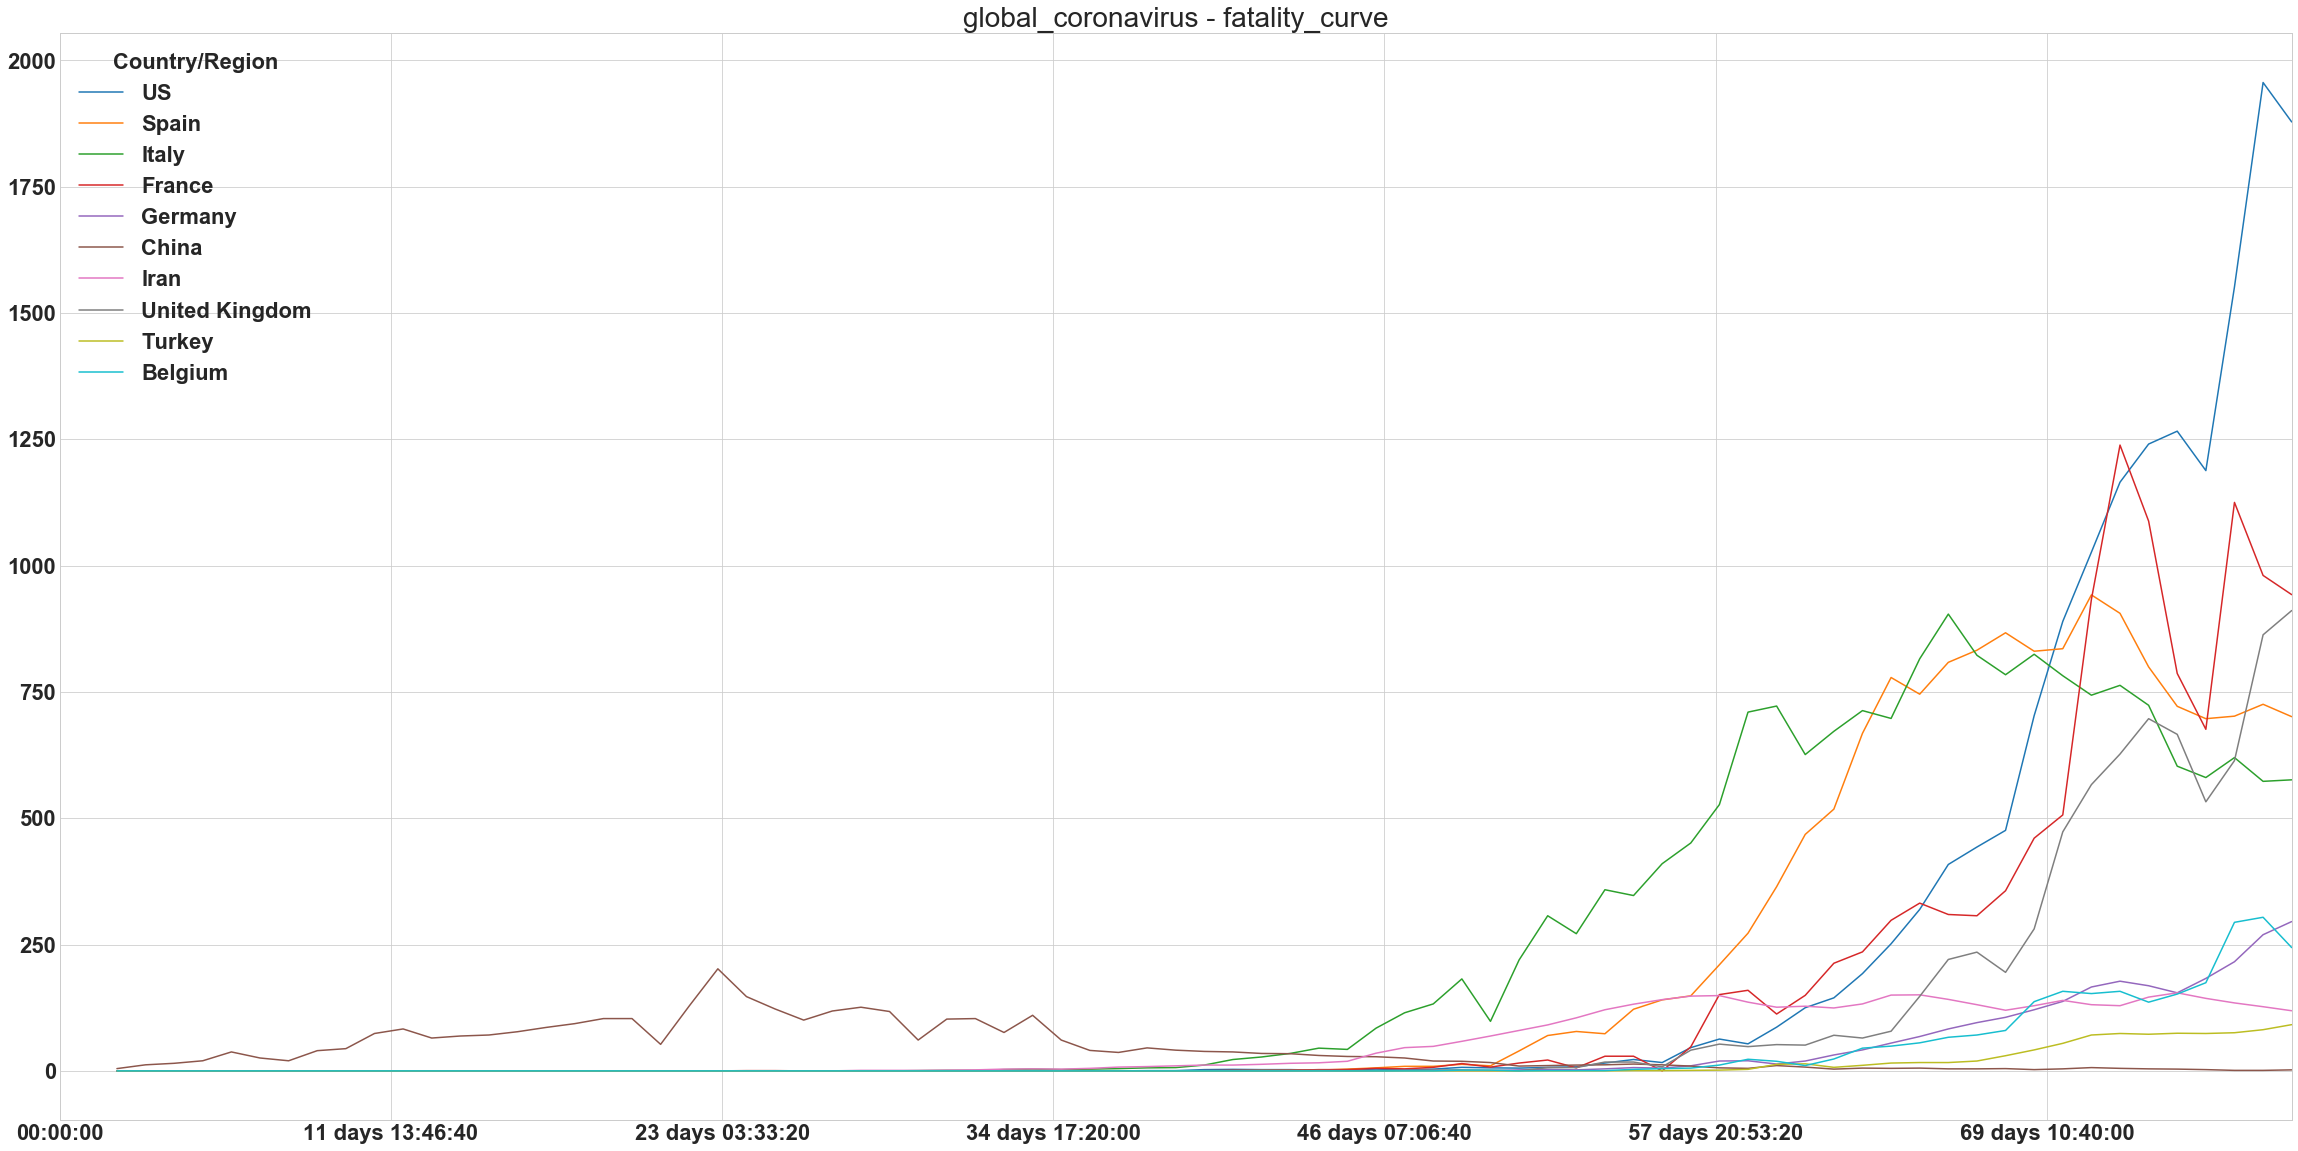

In [134]:
ax = plt.gca()

global_coronavirus_outbreak.fatality_curve.diff().rolling(2).mean().plot(ax=ax)

global_coronavirus_outbreak.add_plot_details(ax, "diff_fatality_curve_ma2")

### Individual Country

In [158]:
italy_df = global_coronavirus_outbreak.get_region_df("Italy")
italy_df["CFR"] = italy_df["Dead"] / italy_df["Infected"]

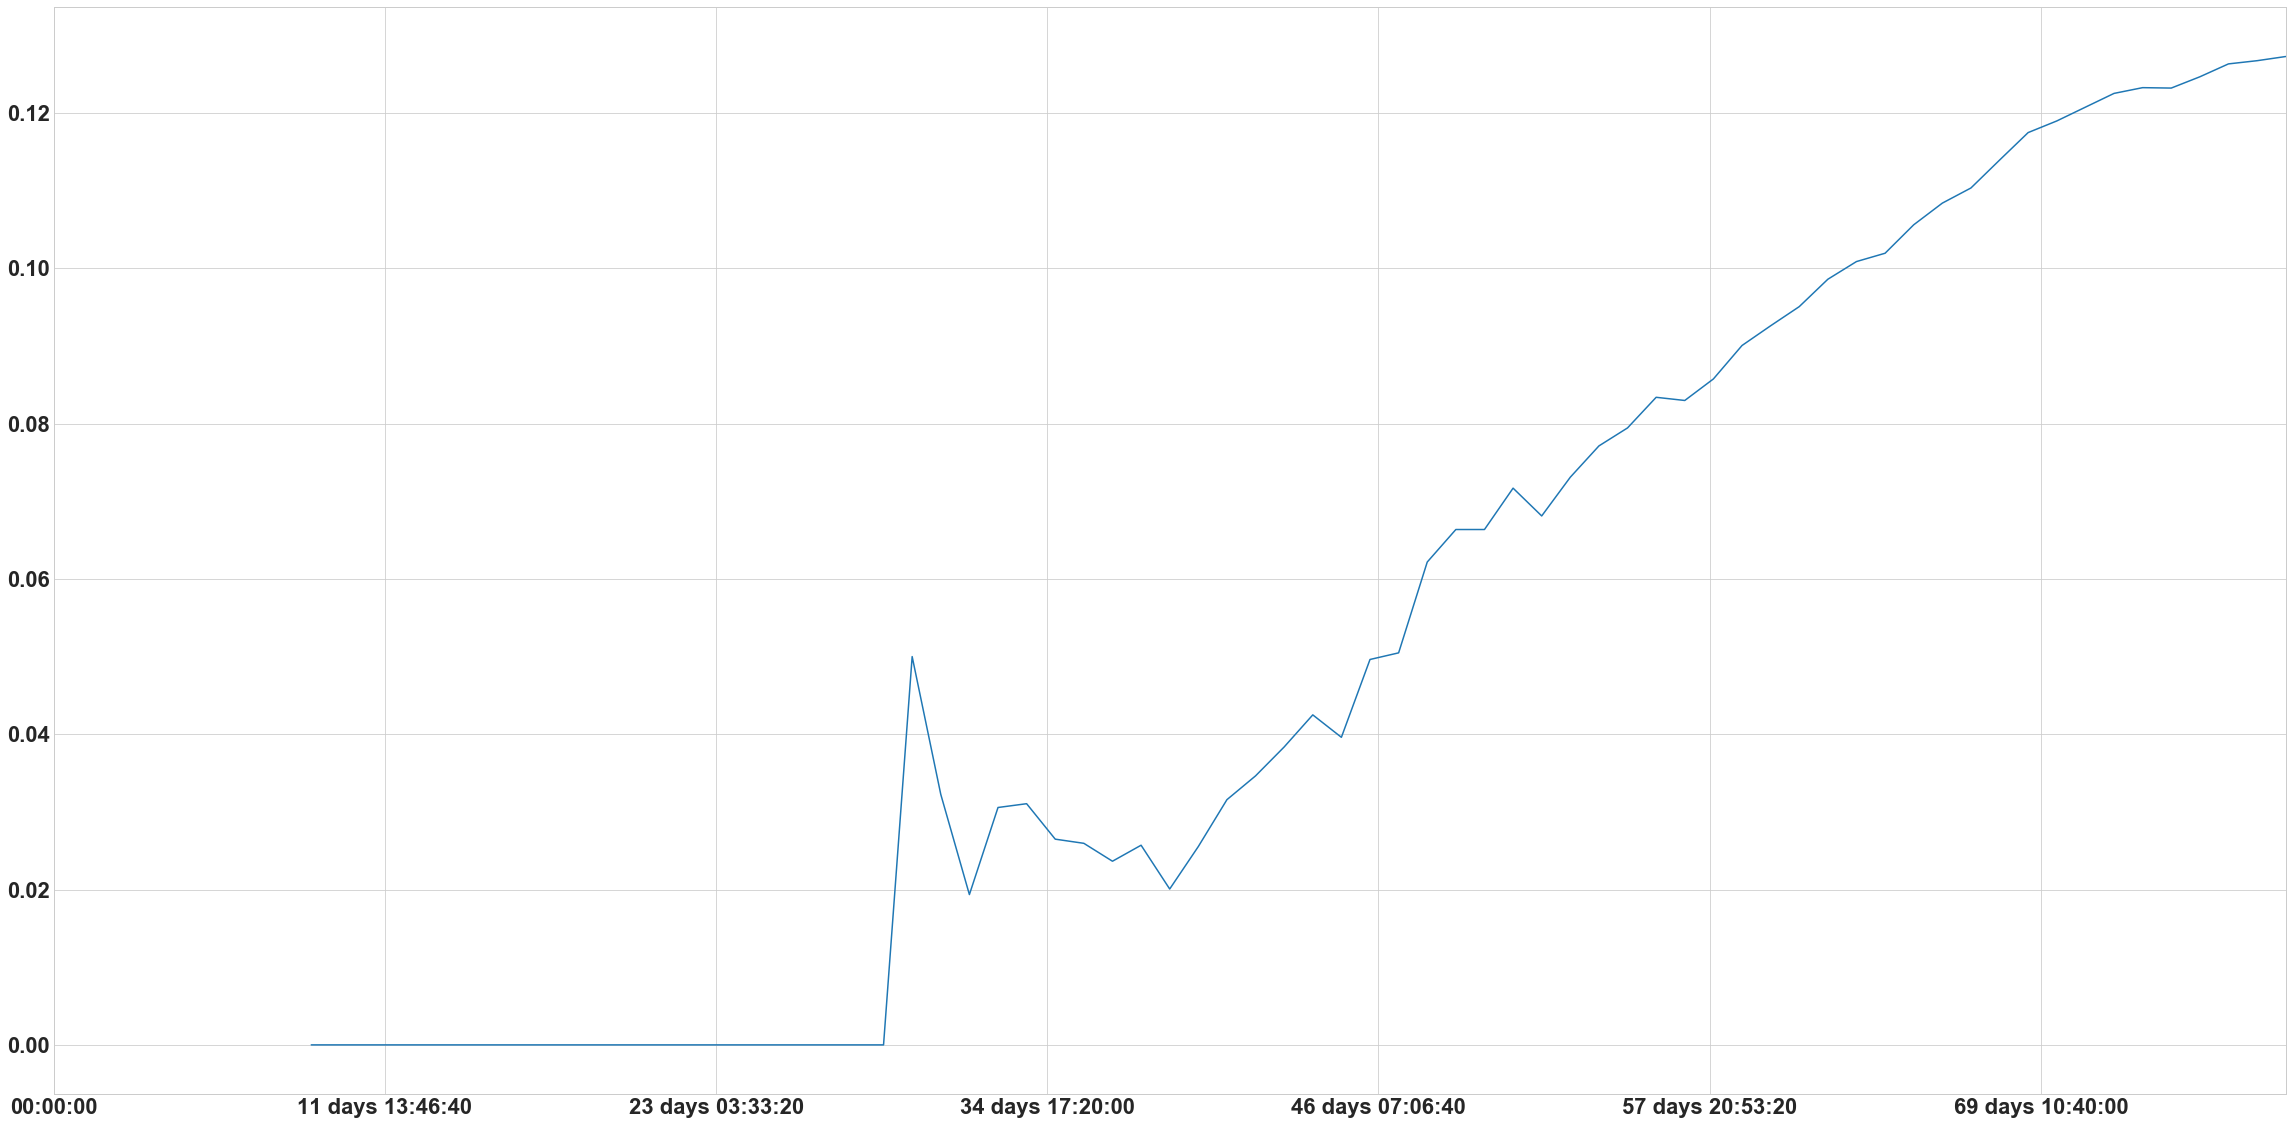

In [160]:
italy_df["CFR"].plot()

### Individual epidemic study

First, we want to convert our indices to time deltas to facilitate manipulation.

In [204]:
# find first day that confirm cases aren't 0 for every country
first_confirmed_case_time_lags = global_confirmed_df.eq(0).sum().apply(lambda x: pd.Timedelta(days=x))
first_death_time_lags = global_death_df.eq(0).sum().apply(lambda x: pd.Timedelta(days=x))

In [210]:
# confirmed
global_confirmed_corrected_df = pd.DataFrame(index=global_confirmed_df.index)
for country, first_day in first_confirmed_case_time_lags.iteritems():
    country_confirmed_curve = global_confirmed_df.loc[first_day:, country]
    country_confirmed_curve.index = country_confirmed_curve.index - first_day
    
    global_confirmed_corrected_df[country] = country_confirmed_curve
    

# death
global_death_corrected_df = pd.DataFrame(index=global_death_df.index)
for country, first_day in first_death_time_lags.iteritems():
    country_death_curve = global_death_df.loc[first_day:, country]
    country_death_curve.index = country_death_curve.index - first_day
    
    global_death_corrected_df[country] = country_death_curve
    
# global_confirmed_corrected_df = global_confirmed_corrected_df.fillna(method='ffill')

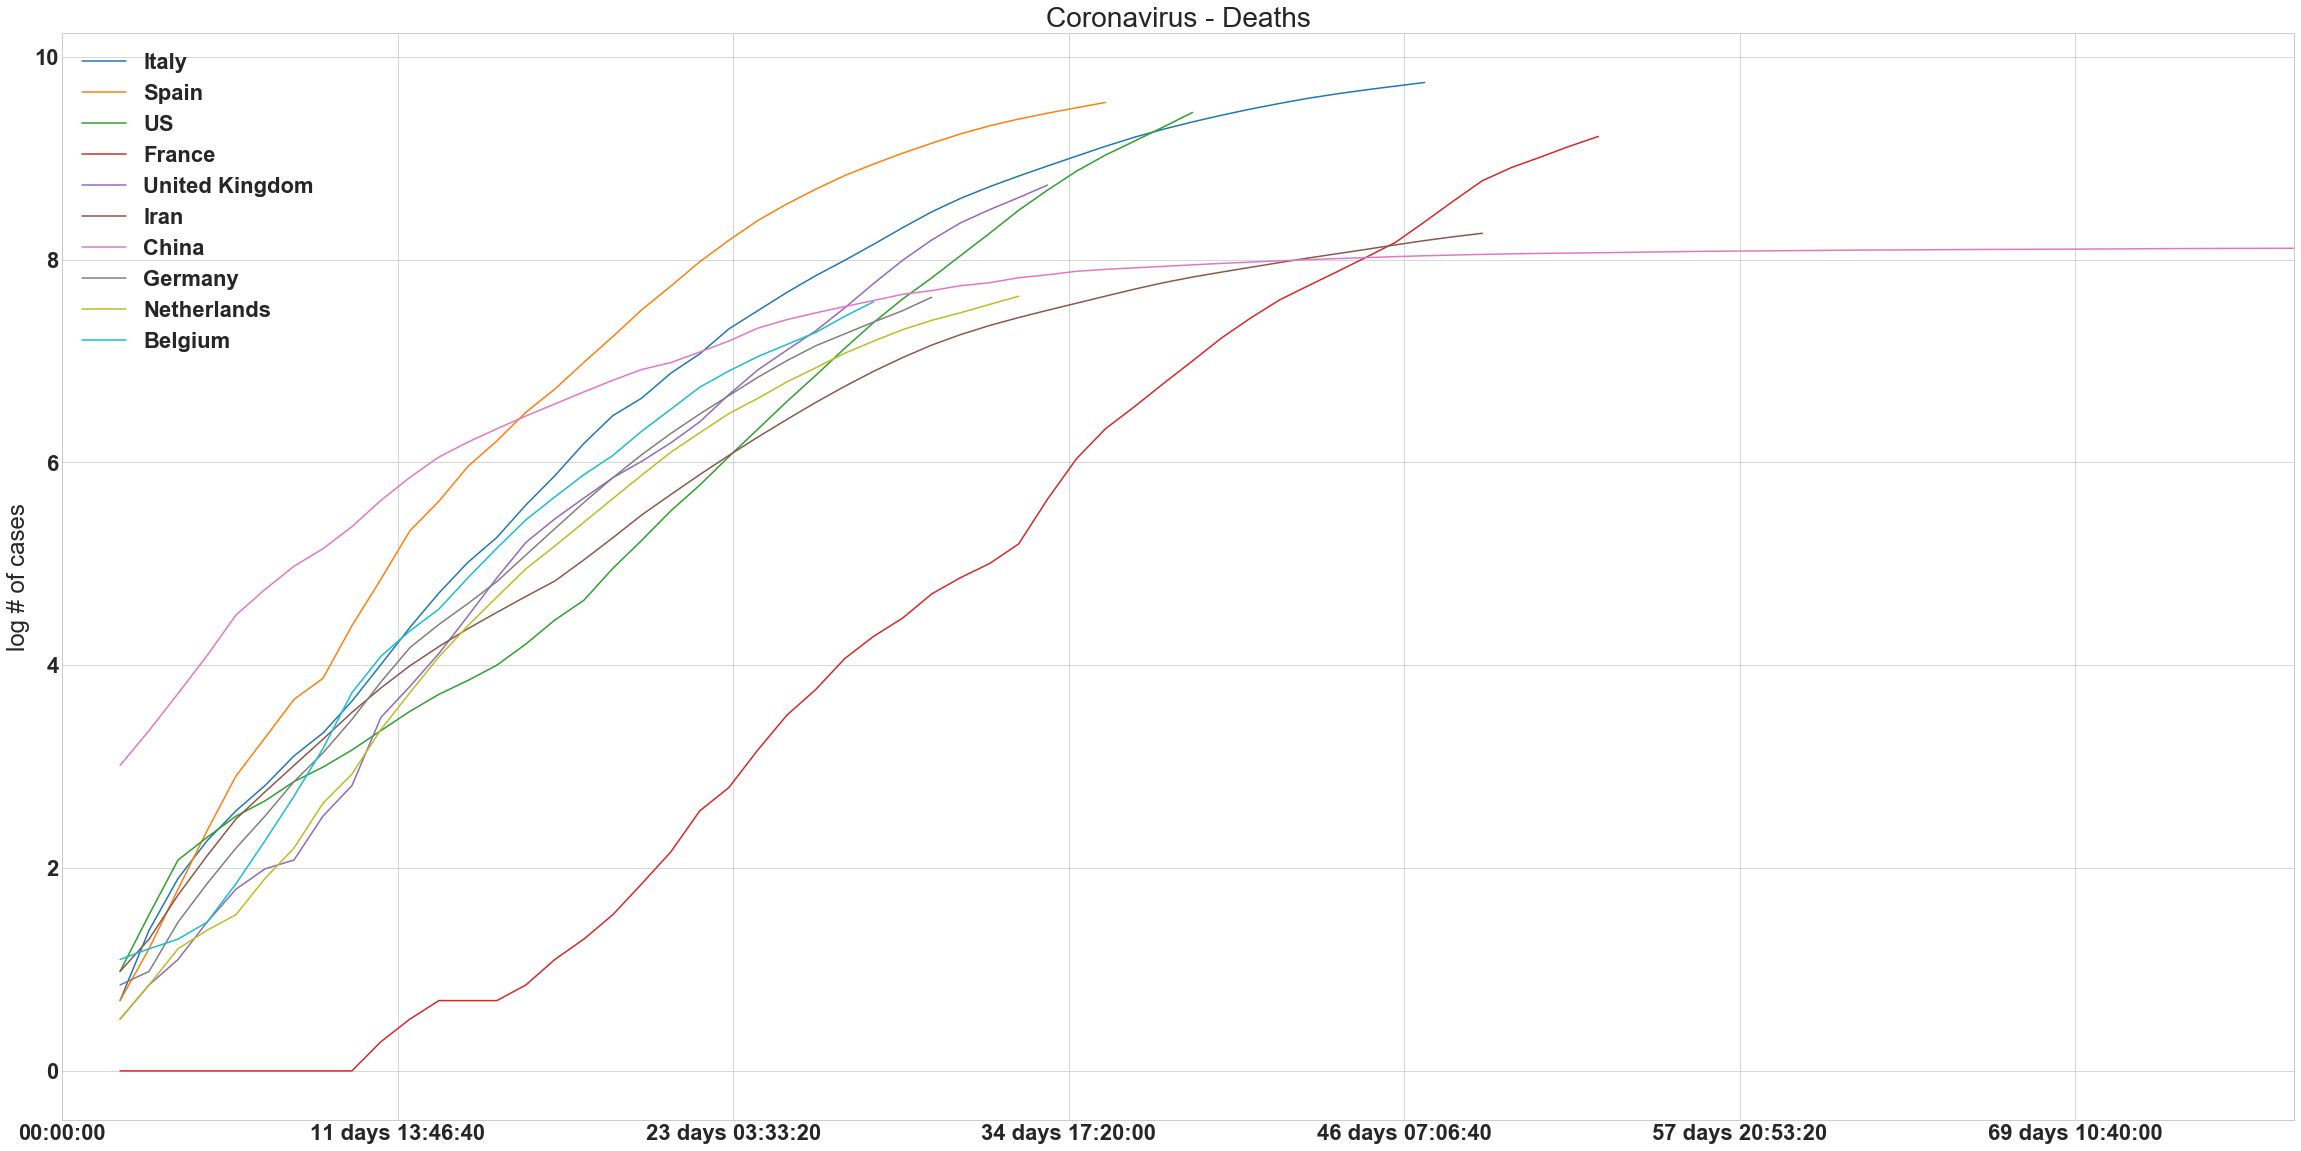

In [221]:
italy_df = global_coronavirus_outbreak

### US

In [126]:
us_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv') \
                    .drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key"], axis=1).groupby('Province_State').sum().transpose()
us_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')\
                .drop(["UID", "iso2", "iso3", "code3", "Admin2", "Lat", "Long_", "FIPS", "Country_Region", "Combined_Key", "Population"], axis=1).groupby('Province_State').sum().transpose()

In [127]:
us_coronavirus_outbreak = Outbreak("us_coronavirus")

us_coronavirus_outbreak.set_epidemic_curve(us_confirmed_df)
us_coronavirus_outbreak.set_fatality_curve(us_death_df)

us_coronavirus_outbreak.convert_indices_to_timedelta_since_epidemic_start_date()

In [128]:
us_coronavirus_outbreak.filter_top_regions()

In [129]:
top_regions_total_number_of_cases = us_coronavirus_outbreak.epidemic_curve.sum(axis=1)[-1]
us_total_number_of_cases = us_coronavirus_outbreak.base_epidemic_curve.sum(axis=1)[-1]

top_regions_total_number_of_deaths = us_coronavirus_outbreak.fatality_curve.sum(axis=1)[-1]
us_total_number_of_deaths = us_coronavirus_outbreak.base_fatality_curve.sum(axis=1)[-1]

print("Case coverage=%.2f" % ((top_regions_total_number_of_cases / us_total_number_of_cases) * 100))
print("Death coverage=%.2f" % ((top_regions_total_number_of_deaths / us_total_number_of_deaths) * 100))

Case coverage=76.33
Death coverage=78.73


We should remove those regions not yet affected by the pandemic.

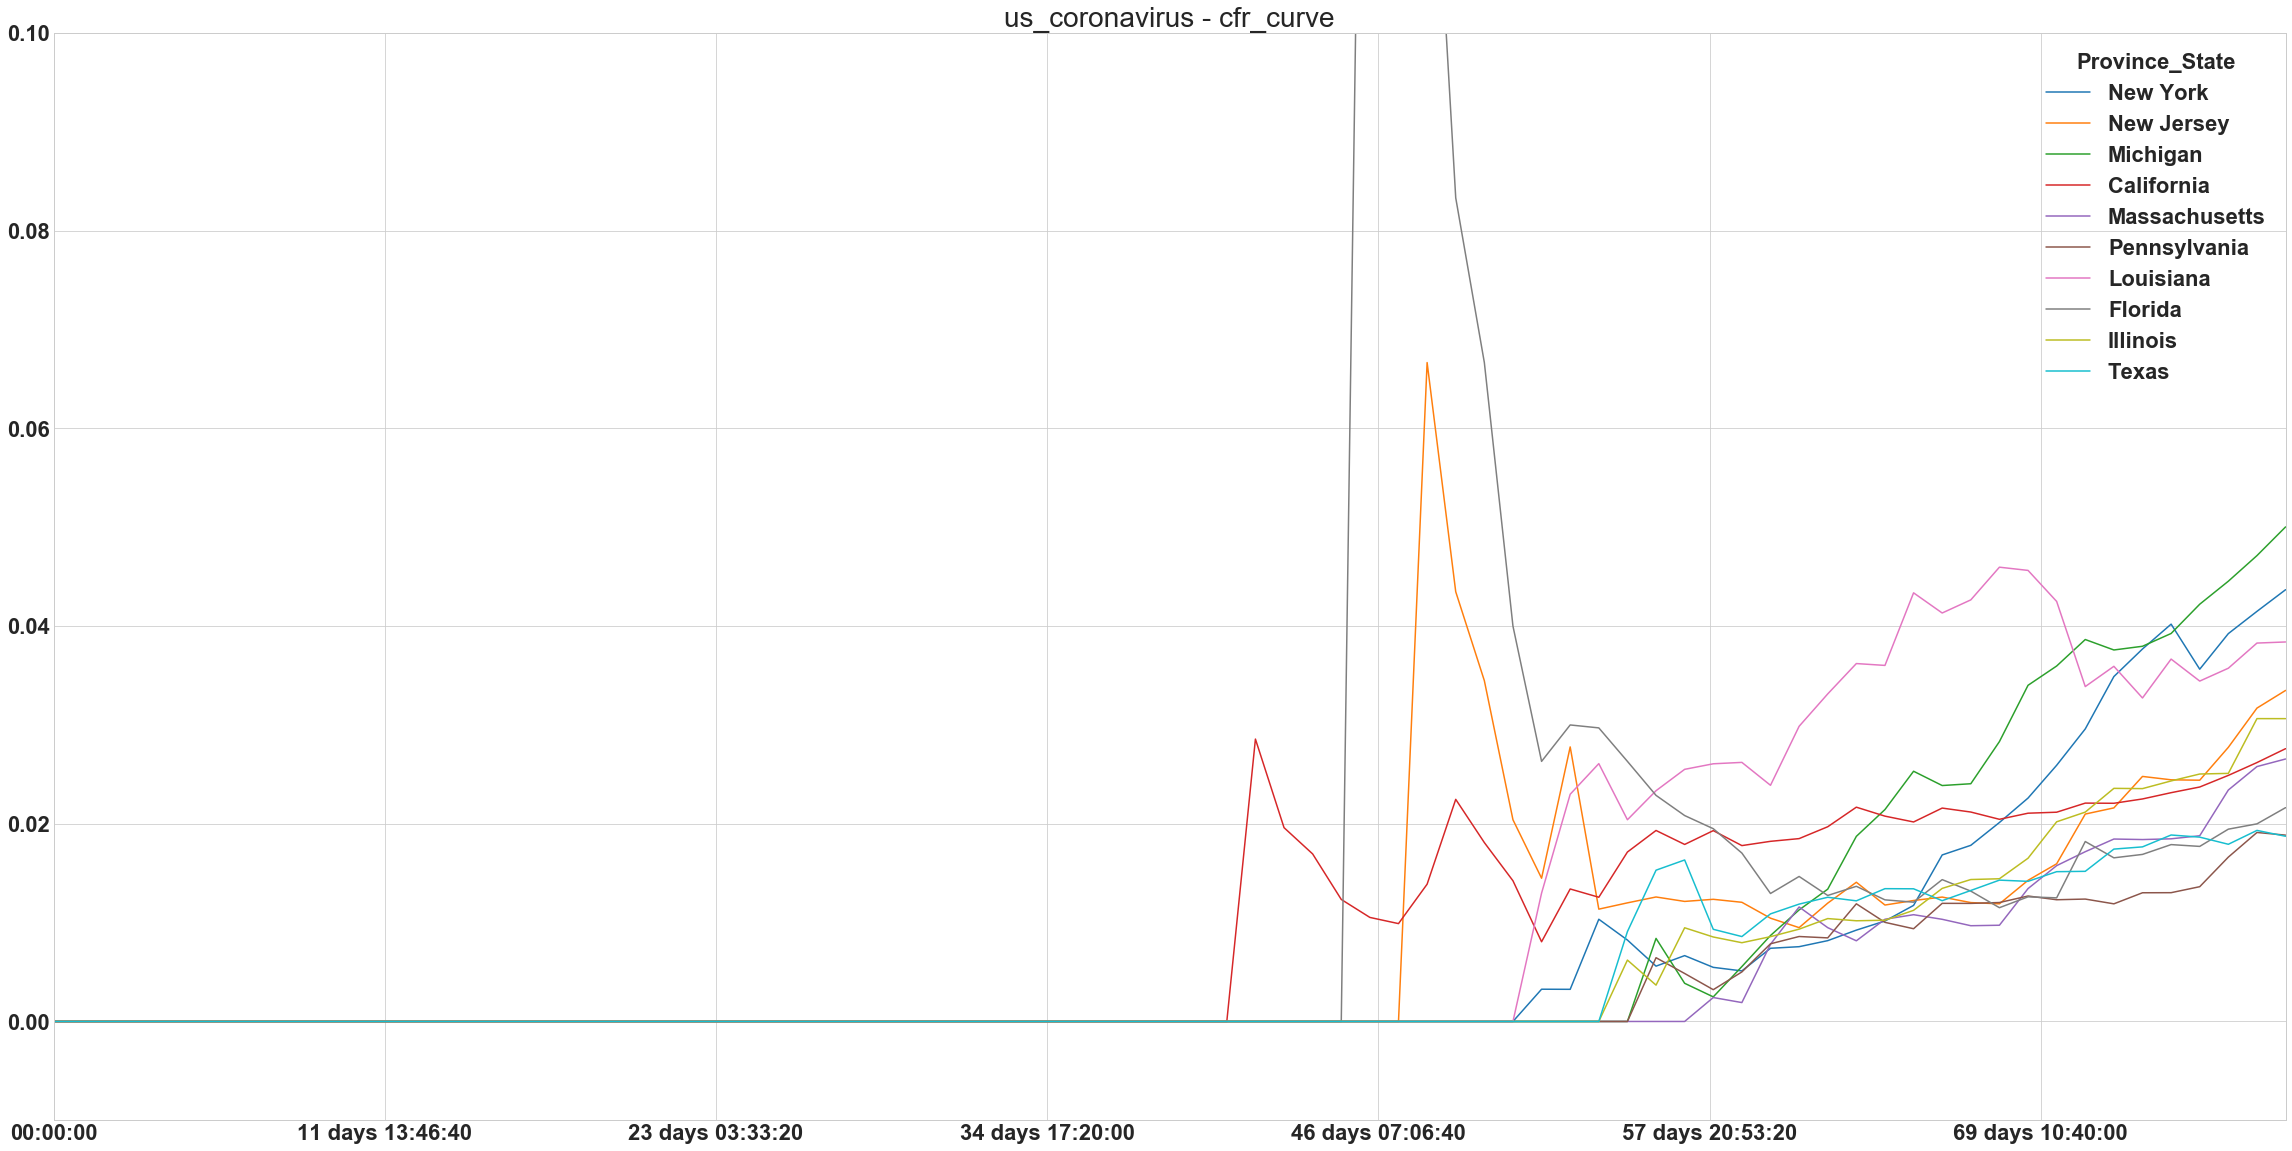

In [132]:
ax = plt.gca()

us_coronavirus_outbreak.cfr_curve.fillna(0).plot(ylim=[-0.01, 0.1], ax=ax)

us_coronavirus_outbreak.add_plot_details(ax, "cfr_curve")